**Fraud Analytics Assignment**  
**Title: Identify clusters using (Node2Vec Embedding, Spectral, and GCN) embeddings**  
---
**Group members:**  
**Name&emsp;: Dindorkar Mayuresh Rajesh**  
**Roll No&nbsp;: CS23MTECH14007**  

**Name&emsp;: Sanyam Kaul**  
**Roll No&nbsp;: CS23MTECH14011**  

**Name&emsp;: Shrenik Ganguli**  
**Roll No&nbsp;: CS23MTECH14014**  

**Name&emsp;: Morey Piyush Prabhakar**  
**Roll No&nbsp;: AI23MTECH14003**  

---

In [1]:
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cpu.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cpu.html
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-1.9.0+cpu.html
!pip install torch-geometric
!pip install gensim

Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cpu.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cpu.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cpu.html


In [2]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.decomposition import PCA
import random
import warnings
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import torch_geometric
from gensim.models import Word2Vec
from tqdm import tqdm
from torch_geometric.utils import add_remaining_self_loops, to_undirected
warnings.filterwarnings("ignore")
from node2vec import Node2Vec
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.manifold import SpectralEmbedding

---  
# Importing data:

In [3]:
df = pd.read_csv('Payments.csv')

In [4]:
df.head()

,Sender,Receiver,Amount
0,1309,1011,123051
1,1309,1011,118406
2,1309,1011,112456
3,1309,1011,120593
4,1309,1011,166396


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130535 entries, 0 to 130534
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   Sender    130535 non-null  int64
 1   Receiver  130535 non-null  int64
 2   Amount    130535 non-null  int64
dtypes: int64(3)
memory usage: 3.0 MB


---  
**Constructing undirected graph where senders and receivers are depicted as nodes and amount is depicted as edges:**

In [6]:
grouped_transactions = df.groupby(['Sender', 'Receiver'])['Amount'].sum().reset_index()
G = nx.from_pandas_edgelist(grouped_transactions, 'Sender', 'Receiver', ['Amount'])

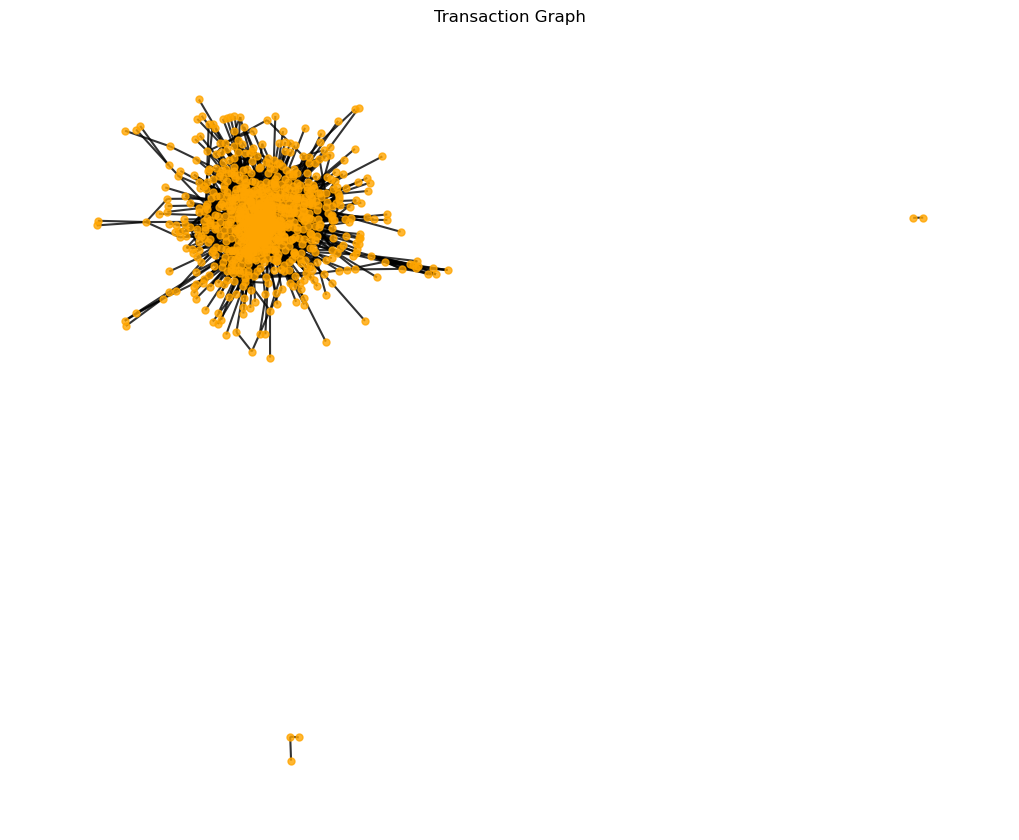

In [7]:
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G) 
nx.draw(G, pos, with_labels=False, node_color='orange', node_size=25, edge_color='black', width=1.5, alpha=0.8)
plt.title('Transaction Graph')
plt.show()

---  
## Node2Vec Embedding:

**Function implemented to do Node2Vec embeddings of nodes:**

In [8]:
def generate_weighted_random_walks(graph, num_walks, walk_length, weight_key):
    walks = []
    nodes = list(graph.nodes())
    
    for _ in range(num_walks):
        np.random.shuffle(nodes)
        for node in nodes:
            walk = [node]
            while len(walk) < walk_length:
                neighbors = list(graph.neighbors(walk[-1]))
                if neighbors:
                    weights = [graph[walk[-1]][neighbor][weight_key] for neighbor in neighbors]
                    total_weight = sum(weights)
                    probabilities = [weight / total_weight for weight in weights]
                    next_node = np.random.choice(neighbors, p=probabilities)
                    walk.append(next_node)
                else:
                    break
            walks.append(walk)
    
    return walks

In [9]:
def node_embedding(graph, dimensions, num_walks, walk_length, weight_key):
    walks = generate_weighted_random_walks(graph, num_walks, walk_length, weight_key)
    model = Word2Vec(walks, vector_size=dimensions, window=5, min_count=1, sg=1, workers=4)
    print(model.wv)
    embeddings = {str(node): model.wv[node] if node in model.wv else np.zeros(dimensions) for node in graph.nodes}
    
    return embeddings

**Calculating Node2Vec embeddings using self-implemented logic:**

In [10]:
embeddings = node_embedding(G, dimensions=64, num_walks=100, walk_length=4, weight_key='Amount')

KeyedVectors<vector_size=64, 799 keys>


In [11]:
print("Embedding of node '1001' using self-made Node2Vec:", embeddings['1001'])

Embedding of node '1001' using self-made Node2Vec: [ 0.01739496  0.3707183   0.5297652   0.30679938  0.47519228 -0.09961366
  0.22834882 -0.02275099 -0.40912503 -0.15230747  0.05846655 -0.35327774
 -0.9141709   0.2719348  -0.57114893 -0.6286575  -0.25155622 -0.26414615
  0.05756566  1.2558662   0.61421174  1.2275671   0.26366717 -0.577272
  0.07410148  0.409341    0.11184189 -0.13908856  0.34343377 -0.2406064
  0.17004274 -0.04547098  0.48431146  0.05430085 -0.12473547 -0.3468028
  0.30651802 -0.11261325  0.5083193   0.37589797  0.01351986 -0.67174697
  0.08364986  0.28241482  0.7074294  -0.5772526  -0.67146796 -0.54318607
 -0.2892237  -0.27372885 -0.06882793  0.07017114  0.1764142   0.40948358
  0.68802845  0.09694913  0.25680518  0.55622417  0.05583394 -0.626047
 -0.255182   -0.21414372 -0.2790968  -0.07653799]


**Calculating Node2Vec embedding using sklearn's Node2Vec function for comparison with self-implemented function:**

In [12]:
node2vec = Node2Vec(G, dimensions=64, walk_length=4, num_walks=100, workers=4, p=1, q=0.5, weight_key='Amount')
model = node2vec.fit(window=10, min_count=1)
embeddings_from_in_built = {str(node): model.wv[str(node)] for node in G.nodes}
print("Embedding of node '1001' using in-built Node2Vec:", embeddings_from_in_built['1001'])

Computing transition probabilities:   0%|          | 0/799 [00:00<?, ?it/s]

Embedding of node '1001' using in-built Node2Vec: [ 0.5771264  -0.37411314  0.86605597 -0.23438515  0.33222735 -0.6445094
  0.6398458  -0.03122019 -0.22010385  0.64708614  0.0882019  -0.04792463
 -0.6518125  -0.46539205 -0.18155101  0.7126742   0.05273679 -0.08323808
  0.312632    1.0990008   0.47851953  0.23834622 -0.18701932 -0.11861763
 -0.64201754  0.31494483 -0.05504871  0.19193722  0.0965369   0.21324353
  0.6330939   0.16107461  0.5424428  -0.43604305  0.09111    -0.20737211
  0.73295945  0.04144788 -0.01107858  0.0589246   0.8475466   0.05203856
 -0.2197563   0.65123653  0.6825577   0.3938318  -0.20370883 -0.5112955
 -0.31447974  0.40440404 -0.20744936 -0.43990597  0.0540231   0.40869597
  0.38707572  0.25703344  0.00942372  0.07694004 -0.38075438 -0.39264742
 -0.69452745 -0.4378003  -0.31295723  0.25898275]


**Simulating Graph Walks performed on G for Node2Vec embedding:**

In [13]:
def transition_probability(G, node, neighbor, p=1, q=1, weight='Amount'):
    if node == neighbor:
        return 1
    elif G.has_edge(node, neighbor):
        weight = G[node][neighbor].get(weight, 1) 
        return 1 / weight
    else:
        return 1 / 1

def simulate_walks(G, num_walks, walk_length, p=1, q=1, weight='Amount'):
    walks = []
    nodes = list(G.nodes)
    for _ in range(num_walks):
        random.shuffle(nodes)
        for node in nodes:
            walk = [node]
            while len(walk) < walk_length:
                current_node = walk[-1]
                neighbors = list(G.neighbors(current_node))
                if len(neighbors) > 0:
                    probabilities = [transition_probability(G, current_node, neighbor, p, q, weight) for neighbor in neighbors]
                    probabilities /= np.sum(probabilities)
                    chosen_neighbor = np.random.choice(neighbors, p=probabilities)
                    walk.append(chosen_neighbor)
                else:
                    break
            walks.append(walk)
    return walks

num_walks = 100
walk_length = 4
p = 1
q = 1
walks = simulate_walks(G, num_walks, walk_length, p, q, weight='Amount')

In [14]:
print(f'Printing on for the  graph walks: {walks[0]}')

Printing on for the  graph walks: [1571, 1550, 1961, 1550]


**Applying PCA for dimensionality reduction on the Node2Vec embedding done using our self-written Node2Vec implementation:**  
- Reducing the embedding to 2-D for plotting

In [15]:
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(list(embeddings.values()))

**Plotting Elbow curve to find out the number of clusters for K-Means:**

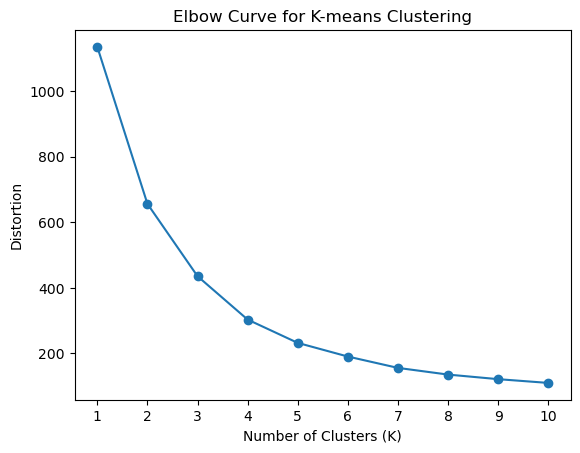

In [16]:
distortions = []
max_k = 10

for k in range(1, max_k + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(list(embeddings_pca))
    distortions.append(kmeans.inertia_)

plt.plot(range(1, max_k + 1), distortions, marker='o')
plt.title('Elbow Curve for K-means Clustering')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Distortion')
plt.xticks(np.arange(1, max_k + 1, 1))
plt.show()

**Plotting Silhouette Analysis of the K-means Clustering as the Eblow curve does not have any sharp elbow to rely on:**

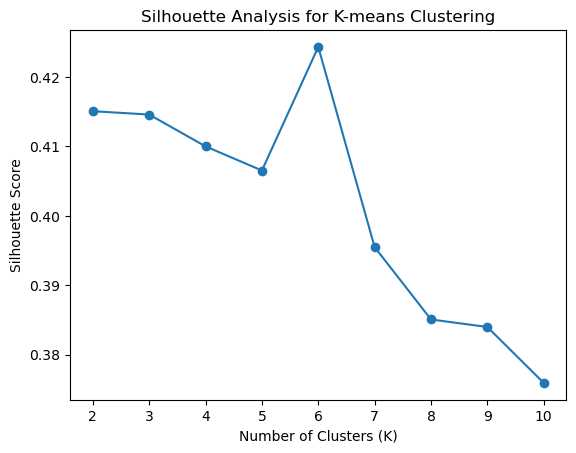

In [17]:
max_k = 10
kmeans_scores = []
for k in range(2, max_k+1):
    kmeans = KMeans(n_clusters=k)
    kmeans_clusters = kmeans.fit_predict(list(embeddings_pca))
    silhouette_avg = silhouette_score(list(embeddings_pca), kmeans_clusters)
    kmeans_scores.append(silhouette_avg)

plt.plot(range(2, max_k+1), kmeans_scores, marker='o')
plt.title('Silhouette Analysis for K-means Clustering')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.show()

**Using K = 6 as the Silhouette Analysis shows maximum score on K=6 for K-Means:**

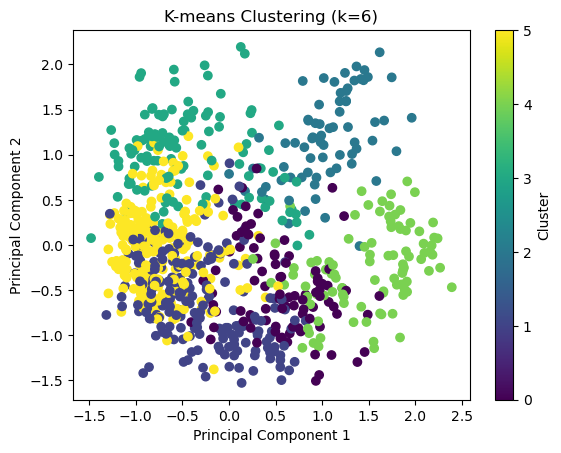

In [18]:
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans_clusters = kmeans.fit_predict(list(embeddings.values()))

plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=kmeans_clusters, cmap='viridis')
plt.title('K-means Clustering (k=6)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

---  
## Spectral Embedding:

**Implementation of self-made logic for Spectral embedding:**

In [19]:
adjacency_matrix = nx.to_numpy_matrix(G)
num_components = 64

def spectral_embedding(adjacency_matrix, num_components):
    degree_matrix = np.diag(np.sum(adjacency_matrix, axis=1))
    laplacian_matrix = degree_matrix - adjacency_matrix
    
    eigenvalues, eigenvectors = np.linalg.eigh(laplacian_matrix)
    
    sorted_indices = np.argsort(eigenvalues)
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    
    embedding_matrix = sorted_eigenvectors[:, 1:num_components + 1]
    
    return embedding_matrix

**Calculating Spectral Embedding using our self-implemented function:**

In [20]:
embeddings_spectral = spectral_embedding(adjacency_matrix, num_components)

**Calculating spectral embedding using sklearn's function for comparison with our self-implemented function:**

In [21]:
spectral_embedding = SpectralEmbedding(n_components=64, random_state=42)
embeddings_spectral_from_built_in = spectral_embedding.fit_transform(list(embeddings.values()))

In [22]:
print("Spectral embedding of node '1001' using self implementation of spectral_embedding function:", embeddings_spectral[0])

Spectral embedding of node '1001' using self implementation of spectral_embedding function: [[-0.07944675  0.03851189  0.01777971 -0.04157602  0.05270947 -0.01208972
   0.02172648 -0.03174409  0.03093247  0.01247625 -0.03704415  0.0818202
  -0.02984574  0.05860913 -0.1138416   0.03846872 -0.09080102  0.01743078
  -0.0717865   0.06066476 -0.04767179 -0.021197    0.0568439   0.01939554
  -0.02904566  0.01597922  0.05995396 -0.03841773 -0.00871629 -0.00720528
  -0.01742817  0.07146678  0.11609176 -0.01543206 -0.07073286  0.0017499
  -0.05044132  0.06327947 -0.08672188  0.01751048 -0.00761514  0.04705579
  -0.05222924  0.07252225 -0.03503814  0.0765219  -0.01426711  0.02548788
  -0.01915599  0.06493348 -0.06050668 -0.01768608  0.0735719  -0.07343104
   0.17514391 -0.01632287 -0.01056859  0.03936997  0.03017465 -0.10131735
   0.08696452  0.00349601 -0.04301216  0.13882516]]


In [23]:
print("Spectral embedding of node '1001' using built-in spectral_embedding function:", embeddings_spectral[0])

Spectral embedding of node '1001' using built-in spectral_embedding function: [[-0.07944675  0.03851189  0.01777971 -0.04157602  0.05270947 -0.01208972
   0.02172648 -0.03174409  0.03093247  0.01247625 -0.03704415  0.0818202
  -0.02984574  0.05860913 -0.1138416   0.03846872 -0.09080102  0.01743078
  -0.0717865   0.06066476 -0.04767179 -0.021197    0.0568439   0.01939554
  -0.02904566  0.01597922  0.05995396 -0.03841773 -0.00871629 -0.00720528
  -0.01742817  0.07146678  0.11609176 -0.01543206 -0.07073286  0.0017499
  -0.05044132  0.06327947 -0.08672188  0.01751048 -0.00761514  0.04705579
  -0.05222924  0.07252225 -0.03503814  0.0765219  -0.01426711  0.02548788
  -0.01915599  0.06493348 -0.06050668 -0.01768608  0.0735719  -0.07343104
   0.17514391 -0.01632287 -0.01056859  0.03936997  0.03017465 -0.10131735
   0.08696452  0.00349601 -0.04301216  0.13882516]]


**Applying PCA for dimensionality reduction on the Spectral embedding done using our self-written spectral embedding implementation:**  
- Reducing the embedding to 2-D for plotting

In [24]:
pca_spectral = PCA(n_components=2)
embeddings_pca_spectral = pca_spectral.fit_transform(embeddings_spectral)

**Plotting Elbow curve to find out the number of clusters for K-Means:**

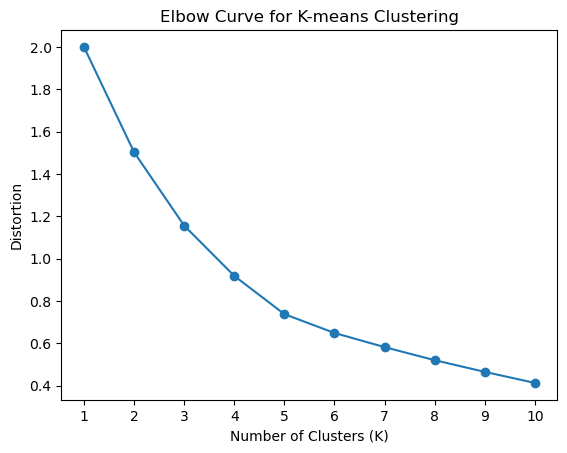

In [25]:
distortions = []
max_k = 10

for k in range(1, max_k + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(list(embeddings_pca_spectral))
    distortions.append(kmeans.inertia_)

plt.plot(range(1, max_k + 1), distortions, marker='o')
plt.title('Elbow Curve for K-means Clustering')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Distortion')
plt.xticks(np.arange(1, max_k + 1, 1))
plt.show()


**Plotting Silhouette Analysis of the K-means Clustering as the Eblow curve does not have any sharp elbow to rely on:**

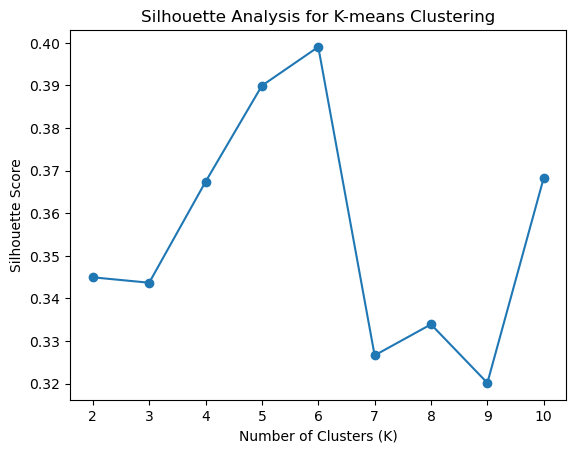

In [26]:
max_k = 10
kmeans_scores = []
for k in range(2, max_k+1):
    kmeans = KMeans(n_clusters=k)
    kmeans_clusters = kmeans.fit_predict(list(embeddings_pca_spectral))
    silhouette_avg = silhouette_score(list(embeddings_pca_spectral), kmeans_clusters)
    kmeans_scores.append(silhouette_avg)

plt.plot(range(2, max_k+1), kmeans_scores, marker='o')
plt.title('Silhouette Analysis for K-means Clustering')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.show()

**Using K = 5 as the Silhouette Analysis shows maximum score on K=5 for K-Means:**

In [47]:
kmeans_spectral_pca = KMeans(n_clusters=6, random_state=42)
kmeans_clusters_spectral_pca = kmeans_spectral_pca.fit_predict(embeddings_pca_spectral)

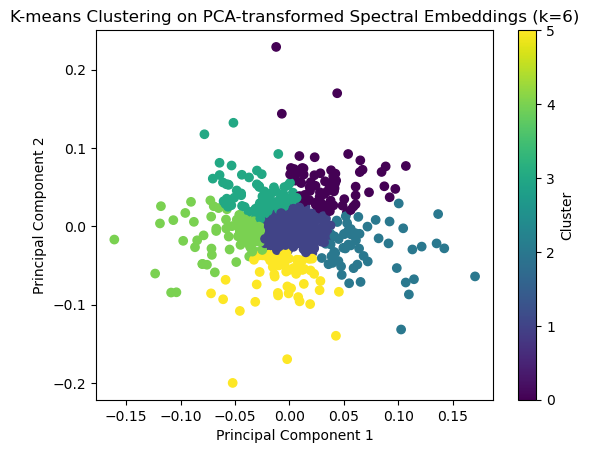

In [48]:
plt.scatter(embeddings_pca_spectral[:, 0], embeddings_pca_spectral[:, 1], c=kmeans_clusters_spectral_pca, cmap='viridis')
plt.title('K-means Clustering on PCA-transformed Spectral Embeddings (k=6)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

---  
## Graph Convolutional Networks (GCN):

In [29]:
degree_centrality_sender = nx.degree_centrality(G)
degree_centrality_receiver = degree_centrality_sender

In [30]:
node_index_map = {node: index for index, node in enumerate(sorted(G.nodes()))}

In [31]:
edges = np.array(list(G.edges()))
edges = torch.tensor(edges, dtype=torch.long).t().contiguous()
edge_attr = torch.tensor(grouped_transactions['Amount'].values, dtype=torch.float)

In [32]:
edges_indexed = torch.tensor([
    [node_index_map[edge.item()] for edge in edges[0]],
    [node_index_map[edge.item()] for edge in edges[1]]
])


**Constructing features for graph nodes:**

In [33]:
degree_centrality = nx.degree_centrality(G)

total_transaction_amount_sender = df.groupby('Sender')['Amount'].sum()
total_transaction_amount_receiver = df.groupby('Receiver')['Amount'].sum()
average_transaction_amount_sender = df.groupby('Sender')['Amount'].mean()
average_transaction_amount_receiver = df.groupby('Receiver')['Amount'].mean()
transaction_frequency_sender = df['Sender'].value_counts()
transaction_frequency_receiver = df['Receiver'].value_counts()

node_features_df = pd.DataFrame({
    'DegreeCentrality': degree_centrality,
    'TotalTransactionAmount_Sender': total_transaction_amount_sender,
    'TotalTransactionAmount_Receiver': total_transaction_amount_receiver,
    'AverageTransactionAmount_Sender': average_transaction_amount_sender,
    'AverageTransactionAmount_Receiver': average_transaction_amount_receiver,
    'TransactionFrequency_Sender': transaction_frequency_sender,
    'TransactionFrequency_Receiver': transaction_frequency_receiver
}).fillna(0)

**Defining node features:**

In [34]:
num_nodes = len(node_features_df)
num_features = len(node_features_df.columns)
node_features = torch.tensor(node_features_df.values, dtype=torch.float)

In [35]:
data = Data(x=node_features, edge_index=edges_indexed, edge_attr=edge_attr)

**Implementation of GCN model:**

In [36]:
class GCN(nn.Module):
    def __init__(self, input_layer_dimension, hidden_layer_dimension, output_layer_dimension):
        super(GCN, self).__init__()
        self.initialize_layers(input_layer_dimension, hidden_layer_dimension, output_layer_dimension)
        
    def initialize_layers(self, input_layer_dimension, hidden_layer_dimension, output_layer_dimension):
        self.conv1 = GCNConv(input_layer_dimension, hidden_layer_dimension)
        self.conv2 = GCNConv(hidden_layer_dimension, output_layer_dimension)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        return self.conv2(x, edge_index)

In [37]:
input_dim = num_features
hidden_dim = 64
output_dim = 32
model = GCN(input_layer_dimension=input_dim, hidden_layer_dimension=hidden_dim, output_layer_dimension=output_dim)

In [38]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

**Training loop:**

In [39]:
num_epochs = 100
for epoch in tqdm(range(num_epochs)):
    model.train()
    optimizer.zero_grad()
    embeddings = model(data.x, data.edge_index)
    loss = torch.norm(embeddings, dim=1).mean()
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

 18%|█▊        | 18/100 [00:00<00:00, 93.03it/s]

Epoch 1/100, Loss: 95215368.0
Epoch 11/100, Loss: 27454102.0
Epoch 21/100, Loss: 14805310.0
Epoch 31/100, Loss: 5391536.0


 69%|██████▉   | 69/100 [00:00<00:00, 146.03it/s]

Epoch 41/100, Loss: 1258503.25
Epoch 51/100, Loss: 304030.96875
Epoch 61/100, Loss: 155730.1875
Epoch 71/100, Loss: 90909.265625


100%|██████████| 100/100 [00:00<00:00, 135.49it/s]

Epoch 81/100, Loss: 54111.78125
Epoch 91/100, Loss: 35415.9609375


**Extracting node embeddings using our self-implemented graph Convolution Network:**

In [40]:
model.eval()
with torch.no_grad():
    gcn_embeddings = model(data.x, data.edge_index)

In [41]:
gcn_embeddings

tensor([[-2.5783e+04,  2.0261e+03, -1.7839e+04,  ...,  1.5477e+04,
          6.6981e+03,  1.2451e+04],
        [ 7.2200e-04, -3.3801e-04, -4.2684e-03,  ...,  1.0754e-03,
          2.0878e-04,  1.1187e-03],
        [ 7.2200e-04, -3.3801e-04, -4.2684e-03,  ...,  1.0754e-03,
          2.0878e-04,  1.1187e-03],
        ...,
        [ 7.2200e-04, -3.3801e-04, -4.2684e-03,  ...,  1.0754e-03,
          2.0878e-04,  1.1187e-03],
        [ 7.2200e-04, -3.3801e-04, -4.2684e-03,  ...,  1.0754e-03,
          2.0878e-04,  1.1187e-03],
        [ 7.2200e-04, -3.3801e-04, -4.2684e-03,  ...,  1.0754e-03,
          2.0878e-04,  1.1187e-03]])

**Applying PCA for dimensionality reduction on the GCN embedding done using our self-written GCN implementation:**  
- Reducing the embedding to 2-D for plotting

In [42]:
pca_gcn = PCA(n_components=2)
embeddings_pca_gcn = pca_gcn.fit_transform(embeddings_spectral)

**Plotting Elbow curve to find out the number of clusters for K-Means:**

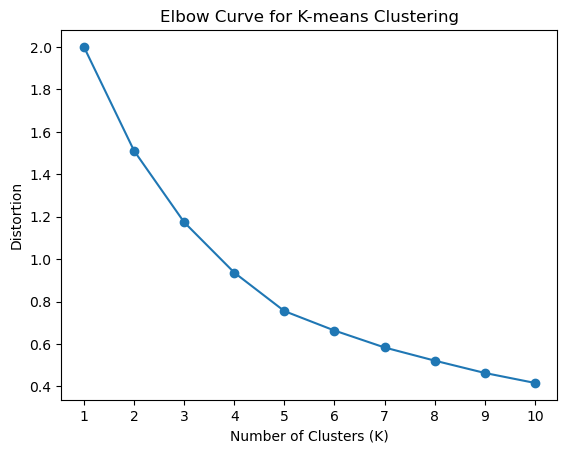

In [43]:
distortions = []
max_k = 10

for k in range(1, max_k + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(list(embeddings_pca_gcn))
    distortions.append(kmeans.inertia_)

plt.plot(range(1, max_k + 1), distortions, marker='o')
plt.title('Elbow Curve for K-means Clustering')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Distortion')
plt.xticks(np.arange(1, max_k + 1, 1))
plt.show()

**Plotting Silhouette Analysis of the K-means Clustering as the Eblow curve does not have any sharp elbow to rely on:**

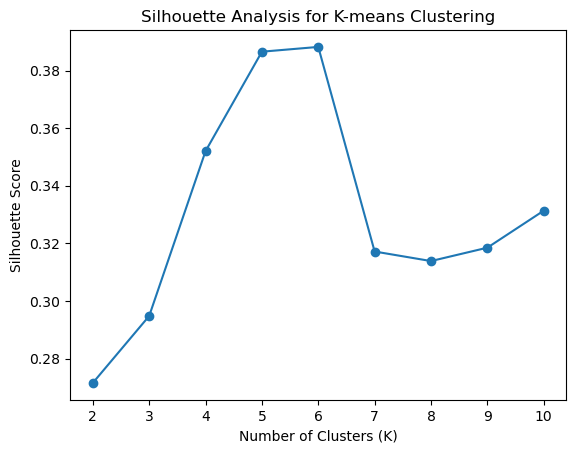

In [44]:
max_k = 10
kmeans_scores = []
for k in range(2, max_k+1):
    kmeans = KMeans(n_clusters=k)
    kmeans_clusters = kmeans.fit_predict(list(embeddings_pca_gcn))
    silhouette_avg = silhouette_score(list(embeddings_pca_gcn), kmeans_clusters)
    kmeans_scores.append(silhouette_avg)

plt.plot(range(2, max_k+1), kmeans_scores, marker='o')
plt.title('Silhouette Analysis for K-means Clustering')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.show()

**Using K = 6 as the Silhouette Analysis shows maximum score on K=6 for K-Means:**

In [45]:
kmeans_gcn_pca = KMeans(n_clusters=6, random_state=42)
kmeans_clusters_gcn_pca = kmeans_gcn_pca.fit_predict(embeddings_pca_gcn)

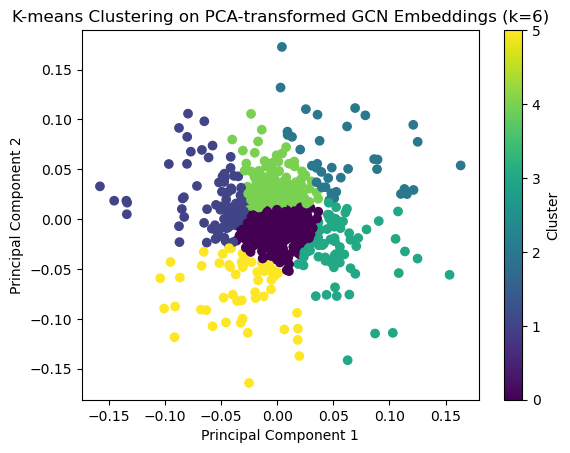

In [46]:
plt.scatter(embeddings_pca_gcn[:, 0], embeddings_pca_gcn[:, 1], c=kmeans_clusters_gcn_pca, cmap='viridis')
plt.title('K-means Clustering on PCA-transformed GCN Embeddings (k=6)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

## Results:  
- Successfully implemented Node2Vec, Spectral and GCN embeddings from scratch
- We can see that the clusters overlap in the case of Node2Vec embedding but get clear boundaries in the case of Spectral and GCN embeddings
- We have seen, after multiple executions, that Elbow curves for all three techniques are gradual with no sharp bend
- The Silhouette Analysis gives the highest score to 5,6 clusters in all three techniques
- Our results come out to be identical when we use in-built functions for embedding which depict that our own implementations are working as expected
